# Predict the total charges using the telco_churn database and linear regression.

# Plan
## Summary: Do any features aside from the obvious predict the total charged a customer? 

'gender', 'senior_citizen', 'partner', 'dependents', 'tenure', 'paperless_billing', 'payment_type_id', 'contract_type_id.1', 'contract_type'

Features that obviously add to the total charged, but do any types of service have a high percentage of high total charges, meaning perhaps they should be marketed?
'phone_service', 'multiple_lines', 'internet_service_type_id', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'contract_type_id','monthly_charges', 'churn', 'internet_service_type_id.1', 'internet_service_type', 'payment_type_id.1', 'payment_type'

Target = total_charges

Recommend adding a planning section to the top of your analysis notebook in order to:
- Summarize the project goals. What's the problem you're trying to solve and why is it important?
- Explain your initial hypothesis or hypotheses that you're going to be testing.
- What is your target variable?
- Why, specifically, is that your target variable?
- Specifically explain which features you are going to be using and which features you're going to be ignoring. Be absolutely certain to explain WHY you are using or dropping certain features. For example, "I'll be using contract_type because ...." and "I'll be ignoring monthly_charges because ..."
- Outline the format of the project:
    - First, I'm going to prepare/wrangle the data
    - Second, I'll explore the data looking for meaningful relationships between our independent variables and the target variables. In the exploration, I'll explain and support why the analysis uses A, B, and C features and ignores X, Y, Z features...
    - Next, I'll develop a baseline predictive model (first draft model)
    - Then, I'll develop a few other models to see if they have more effective and believable predictive power than the baseline model.
    - Before we provide a final suggestion, I'll perform additional feature engineering to see if any derived columns or combinations are more useful than the original features.
    - Finally, I'll provide a suggestion on which model to use, why, and what stakeholders should take away from this analysis. What's the bottom line recommendation and why?

In [1]:
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import numpy as np
import pandas as pd

# Exploring
import scipy.stats as stats

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('classic')

# Modeling
import statsmodels.api as sm

from scipy.stats import pearsonr
from scipy.stats import iqr

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.feature_selection import f_regression

path = './'

### Acquire the data.

In [2]:
full_df = pd.read_csv(path + 'telco_full_data.csv')

### Prepare the data.

Check the datatypes.

In [3]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 27 columns):
customer_id                   7043 non-null object
gender                        7043 non-null object
senior_citizen                7043 non-null int64
partner                       7043 non-null object
dependents                    7043 non-null object
tenure                        7043 non-null int64
phone_service                 7043 non-null object
multiple_lines                7043 non-null object
internet_service_type_id      7043 non-null int64
online_security               7043 non-null object
online_backup                 7043 non-null object
device_protection             7043 non-null object
tech_support                  7043 non-null object
streaming_tv                  7043 non-null object
streaming_movies              7043 non-null object
contract_type_id              7043 non-null int64
paperless_billing             7043 non-null object
payment_type_id               

We'll need total_charges to be numeric, but it looks like 11 rows are missing values.

Check for NaN values.

In [4]:
full_df.isna().any()

customer_id                   False
gender                        False
senior_citizen                False
partner                       False
dependents                    False
tenure                        False
phone_service                 False
multiple_lines                False
internet_service_type_id      False
online_security               False
online_backup                 False
device_protection             False
tech_support                  False
streaming_tv                  False
streaming_movies              False
contract_type_id              False
paperless_billing             False
payment_type_id               False
monthly_charges               False
total_charges                 False
churn                         False
contract_type_id.1            False
contract_type                 False
internet_service_type_id.1    False
internet_service_type         False
payment_type_id.1             False
payment_type                  False
dtype: bool

In [5]:
full_df.isnull().values.sum()

0

Just as I suspected. 11 NaN values in total_charges. Let's fix that.

The errors = 'coerce' parameter causes invalid parsing to be set as NaN.

In [6]:
full_df['total_charges'] = pd.to_numeric(full_df['total_charges'], errors='coerce')

Now fill the missing values with 0s.

In [7]:
full_df['total_charges'] = full_df.total_charges.replace(np.NaN, 0)

Check for nulls and NaNs again...

In [8]:
full_df.isna().any()

customer_id                   False
gender                        False
senior_citizen                False
partner                       False
dependents                    False
tenure                        False
phone_service                 False
multiple_lines                False
internet_service_type_id      False
online_security               False
online_backup                 False
device_protection             False
tech_support                  False
streaming_tv                  False
streaming_movies              False
contract_type_id              False
paperless_billing             False
payment_type_id               False
monthly_charges               False
total_charges                 False
churn                         False
contract_type_id.1            False
contract_type                 False
internet_service_type_id.1    False
internet_service_type         False
payment_type_id.1             False
payment_type                  False
dtype: bool

In [9]:
full_df.isnull().values.sum()

0

That looks good now. Print a sample of the data.

In [10]:
full_df.head(3).append(full_df.tail(3))

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,...,payment_type_id,monthly_charges,total_charges,churn,contract_type_id.1,contract_type,internet_service_type_id.1,internet_service_type,payment_type_id.1,payment_type
0,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,No,...,2,59.90,542.40,No,1,Month-to-month,1,DSL,2,Mailed check
1,0013-MHZWF,Female,0,No,Yes,9,Yes,No,1,No,...,4,69.40,571.45,No,1,Month-to-month,1,DSL,4,Credit card (automatic)
2,0015-UOCOJ,Female,1,No,No,7,Yes,No,1,Yes,...,1,48.20,340.35,No,1,Month-to-month,1,DSL,1,Electronic check
7040,9964-WBQDJ,Female,0,Yes,No,71,Yes,Yes,3,No internet service,...,4,24.40,1725.40,No,3,Two year,3,None,4,Credit card (automatic)
7041,9972-EWRJS,Female,0,Yes,Yes,67,Yes,No,3,No internet service,...,3,19.25,1372.90,No,3,Two year,3,None,3,Bank transfer (automatic)
7042,9975-GPKZU,Male,0,Yes,Yes,46,Yes,No,3,No internet service,...,4,19.75,856.50,No,3,Two year,3,None,4,Credit card (automatic)


In [11]:
full_df.T

,0,1,2,3,4,5,6,7,8,9,...,7033,7034,7035,7036,7037,7038,7039,7040,7041,7042
customer_id,0003-MKNFE,0013-MHZWF,0015-UOCOJ,0023-HGHWL,0032-PGELS,0067-DKWBL,0076-LVEPS,0082-LDZUE,0096-BXERS,0096-FCPUF,...,9814-AOUDH,9838-BFCQT,9916-AYHTC,9938-PRCVK,9945-PSVIP,9950-MTGYX,9953-ZMKSM,9964-WBQDJ,9972-EWRJS,9975-GPKZU
gender,Male,Female,Female,Male,Female,Male,Male,Male,Female,Male,...,Male,Male,Male,Female,Female,Male,Male,Female,Female,Male
senior_citizen,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
partner,No,No,No,No,Yes,No,No,No,Yes,No,...,No,Yes,No,Yes,Yes,Yes,No,Yes,Yes,Yes
dependents,No,Yes,No,No,Yes,No,Yes,No,No,No,...,No,Yes,No,Yes,Yes,Yes,No,No,Yes,Yes
tenure,9,9,7,1,1,2,29,1,6,30,...,53,72,48,41,25,28,63,71,67,46
phone_service,Yes,Yes,Yes,No,No,Yes,No,Yes,Yes,Yes,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
multiple_lines,Yes,No,No,No phone service,No phone service,No,No phone service,No,Yes,Yes,...,No,Yes,No,No,No,No,Yes,Yes,No,No
internet_service_type_id,1,1,1,1,1,1,1,1,1,1,...,3,3,3,3,3,3,3,3,3,3
online_security,No,No,Yes,No,Yes,Yes,Yes,No,No,Yes,...,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service


In [12]:
full_df.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'internet_service_type_id',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract_type_id',
       'paperless_billing', 'payment_type_id', 'monthly_charges',
       'total_charges', 'churn', 'contract_type_id.1', 'contract_type',
       'internet_service_type_id.1', 'internet_service_type',
       'payment_type_id.1', 'payment_type'],
      dtype='object')

What is the shape of the dataframe?

In [13]:
full_df.shape

(7043, 27)

And what is general layout of the data?

In [14]:
full_df.describe()

,senior_citizen,tenure,internet_service_type_id,contract_type_id,payment_type_id,monthly_charges,total_charges,contract_type_id.1,internet_service_type_id.1,payment_type_id.1
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,1.872923,1.690473,2.315633,64.761692,2279.734304,1.690473,1.872923,2.315633
std,0.368612,24.559481,0.737796,0.833755,1.148907,30.090047,2266.794470,0.833755,0.737796,1.148907
min,0.000000,0.000000,1.000000,1.000000,1.000000,18.250000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,9.000000,1.000000,1.000000,1.000000,35.500000,398.550000,1.000000,1.000000,1.000000
50%,0.000000,29.000000,2.000000,1.000000,2.000000,70.350000,1394.550000,1.000000,2.000000,2.000000
75%,0.000000,55.000000,2.000000,2.000000,3.000000,89.850000,3786.600000,2.000000,2.000000,3.000000
max,1.000000,72.000000,3.000000,3.000000,4.000000,118.750000,8684.800000,3.000000,3.000000,4.000000


- We conduct analysis and build models because stakeholders want insight into the contributing factors, especially ones that are non-obvious or ones where they may have only a hunch they want to confirm or deny. Stakeholders want predictive power above and beyond a * b yielding c, so I suggest analyzing different independent variables.

We will only need customer_id, tenure, monthly_charges, and total_charges.

In [15]:
df = full_df[['customer_id', 'tenure', 'monthly_charges', 'total_charges']]

Show the distribution of the monthly charges.

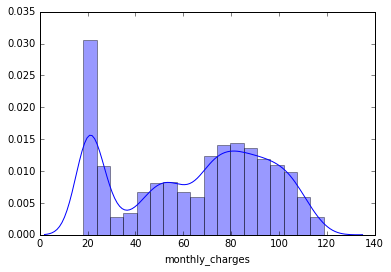

In [16]:
sns.distplot(df.monthly_charges)

Let's make a boxplot of each feature in the dataframe. 

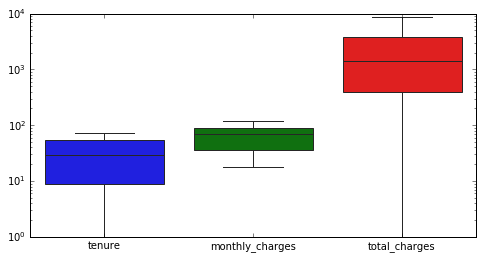

In [17]:
plt.figure(figsize=(8,4))
x_plt = sns.boxplot(data=df.drop(columns=['customer_id']))
x_plt.set_yscale('log')

Now let's split our data into test and train datasets.

In [18]:
X = df.drop(['total_charges', 'customer_id'], axis=1)
y = df[['total_charges']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=123)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

### Explore the data.

Using the full train set with both X_train and y_train, create a scatterplot for each combination of variables.

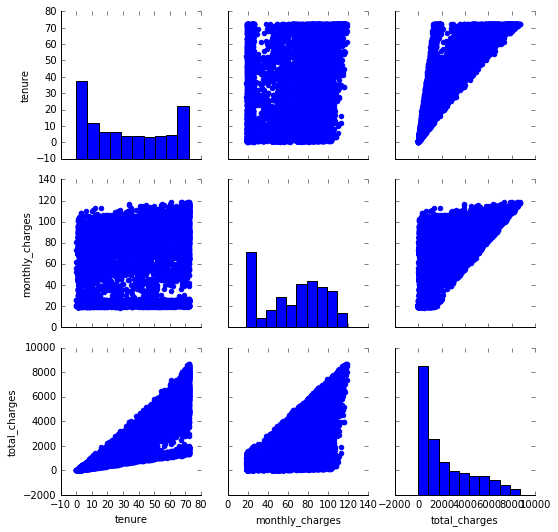

In [19]:
g = sns.PairGrid(train)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)

Now let's look at a heatmap of the three features.

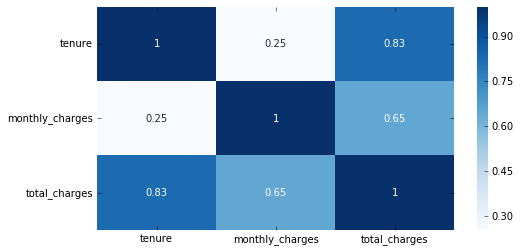

In [20]:
plt.figure(figsize=(8,4))
sns.heatmap(train.corr(), cmap='Blues', annot=True)

- Recommend graphing out the distribution of each of your independent variables before selecting Pearson's R. Definitionally, Pearson's R assumes a normal distribution, and both tenure and monthly_charges are not normally distributed. (Recommend Spearman's R for non-normal distributions). However, Spearman's R gives us 0.0 p-value here due to the relationship between tenure * monthly_charges being super close to total_charges already.

Compute the Pearson correlation coefficients and the p-values for each feature with total_charges.

We use the Pearson correlation coefficient to examine the strength and direction of the linear relationship between two continuous variables. The correlation coefficient can range in value from −1 to +1. The larger the absolute value of the coefficient, the stronger the relationship between the variables.

The p-values give the probability of finding the observed, or more extreme, results in each case.

In [21]:
pearsonsR, pvalue = stats.pearsonr(df.monthly_charges, df.total_charges)
print("For monthly charges and total charges,")
print("Pearson's R is", pearsonsR)
print("with a significance p-value of", pvalue, '.')

For monthly charges and total charges,
Pearson's R is 0.651173831578784
with a significance p-value of 0.0 .


In [22]:
pearsonsR, pvalue = stats.pearsonr(df.tenure, df.total_charges)
print("For tenure and total charges,")
print("Pearson's R is", pearsonsR)
print("with a significance p-value of", pvalue, '.')

For tenure and total charges,
Pearson's R is 0.826178397950242
with a significance p-value of 0.0 .


So tenure has a stronger correlation with total charges than monthly charges does. Both have a p-value of zero, though.

- A p-value of absolutely zero ain't conclusive, it means that we probably need to select different independent variables for our exploration and our model.
- I recommend avoiding monthly_charges and tenure to predict total_charges because the relationship is so tight and direct. When I calculate tenure*monthly_charges, all of the results are within 1% or less of the total_charges field. There's too tight of a relationship between these two variables because we can multiply tenure * monthly_charges and get the total_charges (within 1% or less).

### Model

# Modeling
- I see that the only linear model takes in tenure to predict total_charges. Recommend making a few regressions of your different independent variables that you identified earlier.  
- I recommend making a few models to give yourself options. That way, in the evaluation, you can compare each model and select the one with the least amount of error and highest predictive power.
- Again, I'd recommend building your regression to predict total_charges based on features *other* than tenure and monthly_charges b/c total_charges is the direct multiplication product of both of those.

Train/fit a linear regression model that models total charges as a linear function of tenure.

In [23]:
lm1 = LinearRegression(fit_intercept=False)
lm1.fit(X_train[['tenure']], y_train)
# Find the y-intercept and the coefficent of
# the regression equation, y = mx + b.
lm1_y_intercept = lm1.intercept_
lm1_coefficients = lm1.coef_

In [24]:
print('The linear function, y = mx + b, is')
print('total charges = ', lm1_coefficients[0][0], '* tenure + ', lm1_y_intercept)

The linear function, y = mx + b, is
total charges =  72.82388581167767 * tenure +  0.0


Let's test our model on the training sample. First, create the predictions.

In [25]:
y_pred_lm1 = lm1.predict(X_train[['tenure']])

Now evaluate the model's performance using r-squared, mean squared error, and median absolute error.

In [26]:
mse_lm1 = mean_squared_error(y_train, y_pred_lm1)
mae_lm1 = median_absolute_error(y_train, y_pred_lm1)
r2_lm1 = r2_score(y_train, y_pred_lm1)

print("For lm1:")
print("mse = %.2f" % mse_lm1)
print("mae = %.2f" % mae_lm1)
print(" r2 = %.2f" % r2_lm1)

For lm1:
mse = 1620482.17
mae = 478.77
 r2 = 0.69


Now let's test our model on the test data.

In [27]:
y_pred_test_lm1 = lm1.predict(X_test[['tenure']])

In [28]:
mse_lm2 = mean_squared_error(y_test, y_pred_test_lm1)
mae_lm2 = median_absolute_error(y_test, y_pred_test_lm1)
r2_lm2 = r2_score(y_test, y_pred_test_lm1)

print("For lm1:")
print("mse = %.2f" % mse_lm2)
print("mae = %.2f" % mae_lm2)
print(" r2 = %.2f" % r2_lm2)

For lm1:
mse = 1737852.22
mae = 502.42
 r2 = 0.65


Calculate the p-value of the regressor for the train and test samples.

In [29]:
f_regression(X_test[['tenure']], y_test)

(array([2698.08760902]), array([0.]))

Create a scatter plot of the predicted values versus the actual values in the test sample.

Text(0.5, 1, 'Predicted vs Actual Total Charges')

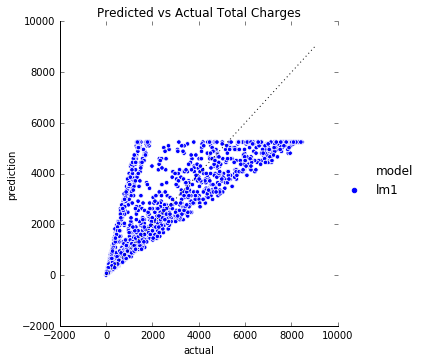

In [30]:
pd.DataFrame({'actual': y_test.total_charges,
              'lm1': y_pred_test_lm1.ravel(),})\
    .melt(id_vars=['actual'], var_name='model', value_name='prediction')\
    .pipe((sns.relplot, 'data'), x='actual', y='prediction', hue='model')

plt.plot([0, 9000], [0, 9000], c='black', ls=':')
plt.title('Predicted vs Actual Total Charges')

Create a scatter plot of the actual values of x and y in the test sample with the regression line layered over.

Text(0.5, 1.0, 'Actual values of x vs Actual values of y')

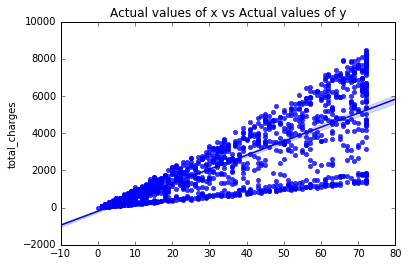

In [31]:
sns.regplot(X_test[['tenure']], y_test.total_charges, data=df);
plt.title('Actual values of x vs Actual values of y')

Create a scatter plot of the residuals. 
- x-axis: predicted values of final grade
- y-axis: the residual values

Layer over it a horizonal line that represents where no residuals would be (residuals = 0).

Text(0, 0.5, 'Residuals')

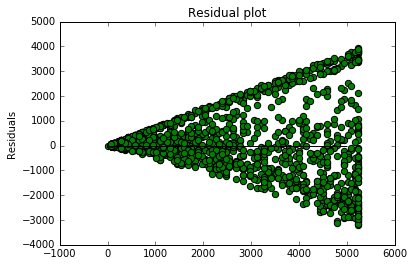

In [32]:
plt.scatter(y_pred_test_lm1, y_pred_test_lm1 - y_test, c='g', s=40)
plt.hlines(y=0, xmin=0, xmax=5000)
plt.title("Residual plot")
plt.ylabel('Residuals')

# Conclusion
- Be sure to state your conclusion and your recommendation both at the beginning and the end of your presentation. What are the conclusions? What are your recommendations?
- Recap your objectives in the conclusion and explain how your analysis supports, rejects, or is inconclusive in predicting your target variable.